In [1]:
import numpy as np
import numpy.fft as fft
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
from collections import defaultdict
from numpy import hamming

In [2]:
PATH = '../WESAD/'
SUBJECTS = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17']
CHEST_SIGNALS = ['ECG', 'EMG', 'EDA', 'Resp', 'Temp', 'ACC']
CHEST_SAMPLING_RATE = 700

In [3]:
def read_subject_data(subject) :
    path = PATH + 'S' + subject + '/S' + subject + '.pkl'
    subject = pd.read_pickle(path)
    
    return subject

In [4]:
def visualize_raw(signal, duration, sampling_rate, title) :
    n = duration * sampling_rate
    l = len(signal)
    
    s = random.randint(0, l - n)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = np.arange(n)
    df['y'] = signal[s:s+n]
    
    plt.figure(figsize=(20, 5))
    sns.scatterplot(x = 'x', y = 'y', data = df, s = 3, color='0').set(title=title)

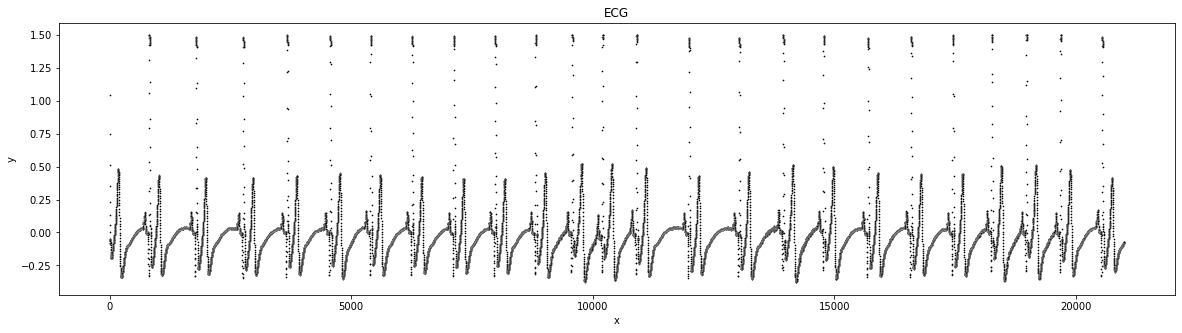

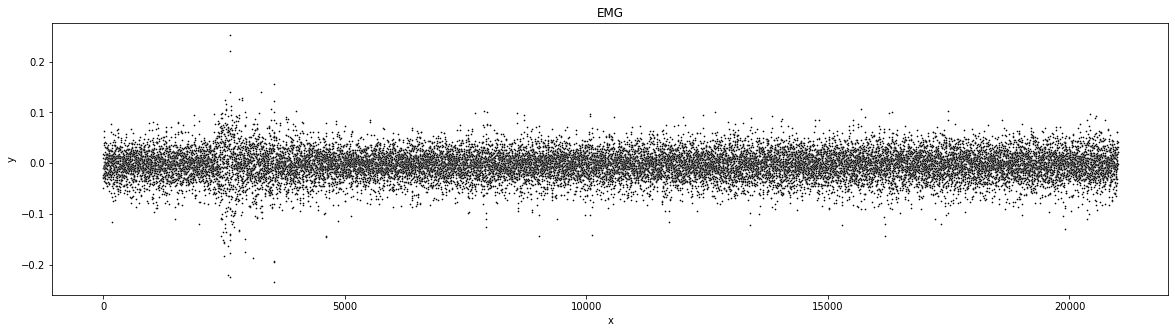

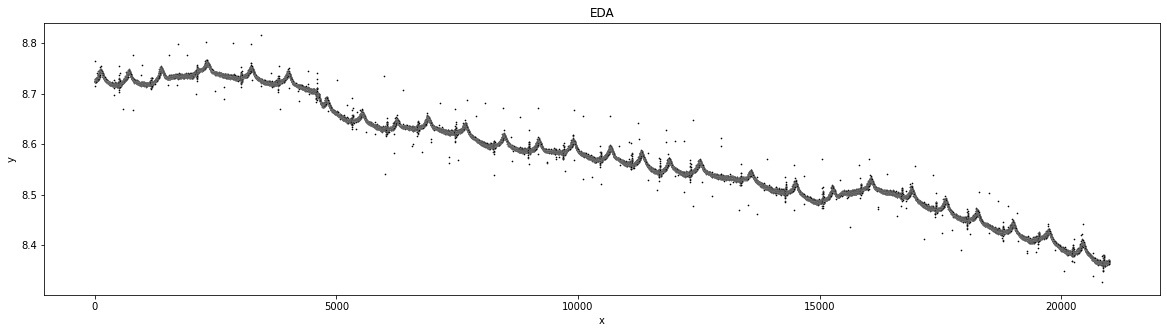

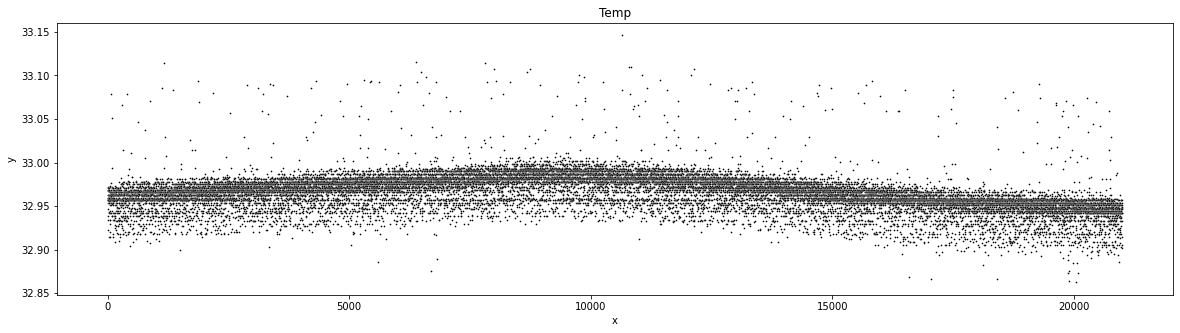

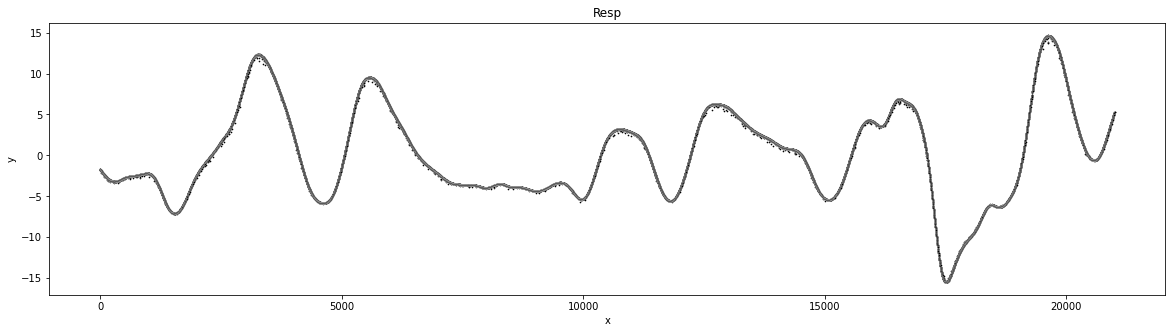

In [5]:
# Visualize the different chest signals
SAMPLING_RATE = 700
DURATION = 30

subject = random.choice(SUBJECTS)
subject_data = read_subject_data(subject)

chest_signals = subject_data['signal']['chest']

for signal_type in chest_signals :
    if signal_type == 'ACC' :
        continue
    
    signal = chest_signals[signal_type]
    visualize_raw(signal, DURATION, SAMPLING_RATE, signal_type)

In [6]:
# https://imotions.com/blog/eda/

# https://www.scitepress.org/Papers/2021/102446/102446.pdf
# https://sci-hub.ee/10.1016/j.cmpb.2020.105482
WINDOW_LEN = 20
OVERLAP = 0.75
NUM_FEATURES = 10

In [7]:
# Identify the continuous intervals for each label
def find_intervals(labels) :
    intervals = []

    l = len(labels)
    i = 0
    label = labels[0]

    for j in range(l):
        if label != labels[j]:
            intervals.append({
                'label' : label, 
                'beg' : i,
                'end' : j
                })
            i = j
            label = labels[j]

    intervals.append({
        'label' : label, 
        'beg' : i,
        'end' : l
    })

    return intervals
    

In [8]:
def extract_fft_features(signal, num_features) :
    window = hamming(len(signal))
    signal *= window
    coeffs = fft.fft(signal)
    l = len(coeffs)
    freqs = fft.fftfreq(l)
    
    # Discard the negative elems
    l //= 2
    amps = np.abs(coeffs[0:l])
    freqs = np.abs(freqs[0:l])
    
    # Sort descending w.r.t amp   
    p = amps.argsort()[::-1]
    freqs = freqs[p]
    amps = amps[p]
    
    features = [[amps[i], freqs[i]] for i in range(num_features)]    
    return np.array(features)

In [9]:
def normalize_fft_features(train_features, test_features) :
    feature_mean = np.mean(train_features, axis=0)
    feature_std = np.std(train_features, axis=0)
    train_features -= feature_mean
    test_features -= feature_mean
    train_features = np.divide(train_features, feature_std, out=np.zeros_like(train_features), where=feature_std!=0)
    test_features = np.divide(test_features, feature_std, out=np.zeros_like(test_features), where=feature_std!=0)
    
    return train_features, test_features

In [10]:
TRANSIENT = 0
BASELINE = 1
STRESS = 2
AMUSEMENT = 3
MEDITATION = 4
IGNORE = 5

def extract_signal_features(signal, intervals, sampling_rate, window_len = WINDOW_LEN, overlap = OVERLAP, num_features = NUM_FEATURES) :
    segment_size = sampling_rate * window_len
    signal_features = {
        BASELINE : [],
        STRESS : [],
        AMUSEMENT : [],
        MEDITATION : []
    }
    
    baseline_av = 0
    
    for interval in intervals :
        label = interval['label']
        beg = interval['beg']
        end = interval['end']
        
        signal_of_interest = signal[beg:end]  
        
        if label >= IGNORE or label == TRANSIENT:
            baseline_av = (np.mean(signal_of_interest) + baseline_av)/2
            continue      
            
        if label == BASELINE :
            baseline_av = (np.mean(signal_of_interest) + baseline_av)/2
        
        signal_of_interest -= baseline_av
        
        l = end - beg        
        while l >= segment_size:
            segment = signal_of_interest[int(l - segment_size) : l]
            l -= int((1 - overlap) * segment_size)
            
            segment_features = extract_fft_features(segment, num_features)            
            signal_features[label].append(segment_features)
        
    return signal_features

In [11]:
def get_chest_signal_dataset(subjects, signal_type) :
    dataset = defaultdict(list)
    for subject in subjects :
        subject_data = read_subject_data(subject)
        intervals = find_intervals(subject_data['label'])
        
        signal = np.array(subject_data['signal']['chest'][signal_type]).flatten()
        
        signal_features = extract_signal_features(signal, intervals, CHEST_SAMPLING_RATE)
        
        for label, feature_vecs in signal_features.items() :
            dataset[label] += list(feature_vecs)
            
    features_dataset = [] 
    label_dataset = []
    
    for label, feature_vecs in dataset.items() :
        for features in feature_vecs :
            features_dataset.append(features)
            label_dataset.append(label)

    return np.array(features_dataset), np.array(label_dataset)

In [12]:
# Get Joint test-train  Datasets combining all signals

def get_agg_chest_signal_dataset(subjects) :
    agg_feature_dataset = []
    agg_labels_dataset = []
    
    for subject in subjects :
        subject_data = read_subject_data(subject)
        intervals = find_intervals(subject_data['label'])
        
        subject_agg = {
            BASELINE : [],
            STRESS : [],
            AMUSEMENT : [],
            MEDITATION : []
        }
        
        for signal_type in CHEST_SIGNALS :
            if signal_type == 'ACC' :
                continue
                
            signal = np.array(subject_data['signal']['chest'][signal_type]).flatten()
            signal_features = extract_signal_features(signal, intervals, CHEST_SAMPLING_RATE)
            
            for label, features in signal_features.items() :
                subject_agg[label].append(features)
                
        for label in subject_agg :
            subject_agg[label] = np.stack(subject_agg[label], axis = 1)
            
        for label, feature_aggs in subject_agg.items() :
            for feature_agg in feature_aggs :
                agg_feature_dataset.append(feature_agg)
                agg_labels_dataset.append(label)

    return agg_feature_dataset, agg_labels_dataset

In [13]:
# Visualize Datasets
def visualize_dataset(features, labels) :
    features = np.array(features)
    amps = np.log10(features[:, :, 0].flatten())
    freqs  = features[:, :, 1].flatten()
    labels = np.repeat(np.array(labels), NUM_FEATURES)
    
    df = pd.DataFrame()
    df['Amp'] = amps
    df['Freq'] = freqs
    df['Label'] = labels
    
    for label, group in df.groupby('Label') :
        plt.figure(figsize=(20, 20))
        sns.scatterplot(x = 'Freq', y = 'Amp', data = group, palette='bright').set(title=label)
    
    plt.figure(figsize=(20, 20))
    sns.scatterplot(x = 'Freq', y = 'Amp', hue = 'Label', style='Label', data = df, palette='bright')

In [14]:
# Get ECG Test-Train Datasets

TRAIN_TEST_RATIO = 0.1

np.random.shuffle(SUBJECTS)
num_subjects = len(SUBJECTS)
k = int ((1 - TRAIN_TEST_RATIO) * num_subjects)

train_features, train_labels = get_agg_chest_signal_dataset(SUBJECTS[0 : k])
test_features, test_labels = get_agg_chest_signal_dataset(SUBJECTS[k : num_subjects])
train_features, test_features = normalize_fft_features(train_features, test_features)

KeyboardInterrupt: 

In [ ]:
def encode_labels(labels) :
    encoder = {
        1 : [1, 0, 0, 0],
        2 : [0, 1, 0, 0],
        3 : [0, 0, 1, 0],
        4 : [0, 0, 0, 1]
    }
    
    return np.array([np.array(encoder[l]) for l in labels])

In [ ]:
train_labels = encode_labels(train_labels)
test_labels = encode_labels(test_labels)

In [1141]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(5, 10, 2)),
    keras.layers.Conv2D(5, kernel_size=(2,2), activation='swish'),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(5, kernel_size=(2,2), activation='swish'),
    keras.layers.Conv2D(6, kernel_size=(2,2), activation='swish'),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(5, kernel_size=(1,2), activation='swish'),
    keras.layers.Conv2D(4, kernel_size=(2,2), activation='swish'),
    keras.layers.Flatten(),
    keras.layers.Dense(units=10,  activation='swish'),
    keras.layers.Dense(units=10,  activation='swish'),
    keras.layers.Dense(units=4)
])

In [1142]:
model.summary()

Model: "sequential_271"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_718 (Conv2D)          (None, 4, 9, 5)           45        
_________________________________________________________________
dropout_383 (Dropout)        (None, 4, 9, 5)           0         
_________________________________________________________________
conv2d_719 (Conv2D)          (None, 3, 8, 5)           105       
_________________________________________________________________
conv2d_720 (Conv2D)          (None, 2, 7, 6)           126       
_________________________________________________________________
dropout_384 (Dropout)        (None, 2, 7, 6)           0         
_________________________________________________________________
conv2d_721 (Conv2D)          (None, 2, 6, 5)           65        
_________________________________________________________________
conv2d_722 (Conv2D)          (None, 1, 5, 4)        

In [1143]:
model.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [1144]:
print(np.shape(train_features), np.shape(train_labels), np.shape(test_features), np.shape(test_labels))

(7586, 5, 10, 2) (7586, 4) (1156, 5, 10, 2) (1156, 4)


In [1145]:
p = np.random.permutation(len(train_features))
train_features, train_labels = train_features[p], train_labels[p]

In [ ]:
model.fit(train_features, train_labels, epochs=400, batch_size = 200, shuffle = True, verbose=1,
              validation_data=(test_features,  test_labels))

Epoch 1/400
38/38 [==============================] - 1s 8ms/step - loss: 1.3560 - accuracy: 0.3984 - val_loss: 1.3183 - val_accuracy: 0.4031
Epoch 2/400
38/38 [==============================] - 0s 4ms/step - loss: 1.2816 - accuracy: 0.4086 - val_loss: 1.2169 - val_accuracy: 0.4152
Epoch 3/400
38/38 [==============================] - 0s 5ms/step - loss: 1.1612 - accuracy: 0.4557 - val_loss: 0.9963 - val_accuracy: 0.5112
Epoch 4/400
38/38 [==============================] - 0s 5ms/step - loss: 0.8142 - accuracy: 0.6198 - val_loss: 0.5972 - val_accuracy: 0.7699
Epoch 5/400
38/38 [==============================] - 0s 5ms/step - loss: 0.6277 - accuracy: 0.7462 - val_loss: 0.6651 - val_accuracy: 0.7500
Epoch 6/400
38/38 [==============================] - 0s 5ms/step - loss: 0.5638 - accuracy: 0.7683 - val_loss: 0.6858 - val_accuracy: 0.7439
Epoch 7/400
38/38 [==============================] - 0s 4ms/step - loss: 0.5277 - accuracy: 0.7806 - val_loss: 0.7183 - val_accuracy: 0.7483
Epoch 8/400
3

Epoch 59/400
38/38 [==============================] - 0s 5ms/step - loss: 0.2631 - accuracy: 0.8993 - val_loss: 0.5154 - val_accuracy: 0.8599
Epoch 60/400
38/38 [==============================] - 0s 5ms/step - loss: 0.2491 - accuracy: 0.9056 - val_loss: 0.4648 - val_accuracy: 0.8702
Epoch 61/400
38/38 [==============================] - 0s 5ms/step - loss: 0.2497 - accuracy: 0.9032 - val_loss: 0.5012 - val_accuracy: 0.8616
Epoch 62/400
38/38 [==============================] - 0s 5ms/step - loss: 0.2508 - accuracy: 0.9054 - val_loss: 0.4677 - val_accuracy: 0.8728
Epoch 63/400
38/38 [==============================] - 0s 5ms/step - loss: 0.2477 - accuracy: 0.9054 - val_loss: 0.4890 - val_accuracy: 0.8616
Epoch 64/400
38/38 [==============================] - 0s 5ms/step - loss: 0.2484 - accuracy: 0.9044 - val_loss: 0.4746 - val_accuracy: 0.8651
Epoch 65/400
38/38 [==============================] - 0s 5ms/step - loss: 0.2420 - accuracy: 0.9085 - val_loss: 0.4847 - val_accuracy: 0.8599
Epoch 

38/38 [==============================] - 0s 6ms/step - loss: 0.1743 - accuracy: 0.9344 - val_loss: 0.5500 - val_accuracy: 0.8927
Epoch 174/400
38/38 [==============================] - 0s 6ms/step - loss: 0.1672 - accuracy: 0.9358 - val_loss: 0.5758 - val_accuracy: 0.8884
Epoch 175/400
38/38 [==============================] - 0s 5ms/step - loss: 0.1718 - accuracy: 0.9341 - val_loss: 0.5668 - val_accuracy: 0.8867
Epoch 176/400
38/38 [==============================] - 0s 6ms/step - loss: 0.1725 - accuracy: 0.9358 - val_loss: 0.5600 - val_accuracy: 0.8910
Epoch 177/400
38/38 [==============================] - 0s 6ms/step - loss: 0.1696 - accuracy: 0.9388 - val_loss: 0.5585 - val_accuracy: 0.8919
Epoch 178/400
38/38 [==============================] - 0s 6ms/step - loss: 0.1689 - accuracy: 0.9324 - val_loss: 0.5742 - val_accuracy: 0.8910
Epoch 179/400
38/38 [==============================] - 0s 6ms/step - loss: 0.1748 - accuracy: 0.9350 - val_loss: 0.5761 - val_accuracy: 0.8858
Epoch 180/400

38/38 [==============================] - 0s 6ms/step - loss: 0.1537 - accuracy: 0.9388 - val_loss: 0.5566 - val_accuracy: 0.8997
Epoch 288/400
38/38 [==============================] - 0s 6ms/step - loss: 0.1498 - accuracy: 0.9407 - val_loss: 0.5944 - val_accuracy: 0.8910
Epoch 289/400
38/38 [==============================] - 0s 6ms/step - loss: 0.1499 - accuracy: 0.9404 - val_loss: 0.5949 - val_accuracy: 0.8971
Epoch 290/400
38/38 [==============================] - 0s 6ms/step - loss: 0.1518 - accuracy: 0.9392 - val_loss: 0.5857 - val_accuracy: 0.8910
Epoch 291/400
38/38 [==============================] - 0s 5ms/step - loss: 0.1564 - accuracy: 0.9400 - val_loss: 0.5873 - val_accuracy: 0.8962
Epoch 292/400
38/38 [==============================] - 0s 6ms/step - loss: 0.1514 - accuracy: 0.9425 - val_loss: 0.6059 - val_accuracy: 0.8832
Epoch 293/400
38/38 [==============================] - 0s 6ms/step - loss: 0.1532 - accuracy: 0.9419 - val_loss: 0.5780 - val_accuracy: 0.8962
Epoch 294/400

In [ ]:
import datetime
! rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [423]:
%reload_ext tensorboard

In [424]:
%tensorboard --logdir logs/fit

In [553]:
model.evaluate(test_features,  test_labels, verbose=2)

37/37 - 0s - loss: 0.4320 - accuracy: 0.8794


[0.43198782205581665, 0.8794143199920654]

In [554]:
model.save('Model_II')

INFO:tensorflow:Assets written to: Model_II/assets


In [1095]:
# import pickle
import pickle

train_features_file = open('train_features_file', 'wb')
test_features_file = open('test_features_file', 'wb')
train_labels_file = open('train_labels_file', 'wb')
test_labels_file = open('test_labels_file', 'wb')

pickle.dump(train_features, train_features_file)
pickle.dump(test_features, test_features_file)
pickle.dump(train_labels, train_labels_file)
pickle.dump(test_labels, test_labels_file)

train_features_file.close()
test_features_file.close()
train_labels_file.close()
test_labels_file.close()

In [ ]:
print(len(train_features), len(test_features))

In [ ]:
t1 = np.array([[[1, 9], [3, 4], [10, 12]], [[5, 6], [7, 8], [13, 11]]])
t2 = np.array([[2, 3], [3, 4]])

t3 = np.max(t1, axis=0)
print(t3)

In [ ]:
np.stack([t1, t1], axis=1)

In [ ]:
np.mean(t1, axis = 0)

In [ ]:
np.std(t1, axis = 0)

In [ ]:
d[1]

In [ ]:
t1[:, :, 0].flatten()

In [ ]:
a, b = zip(*train_dataset.items())

In [ ]:
len(train_features)

In [ ]:
SUBJECTS

In [ ]:
train_features[10]

In [ ]:
num_subjects

In [828]:
np.random.choice(np.arange(23, 30))

27